# Turkey Happiness EDA
Data source: http://tuik.gov.tr -> Veritabanları -> Yaşam Memnuniyeti

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
happy = pd.read_excel('data/Turkey general happiness score.xls')

In [3]:
happy = happy.reset_index().drop([0,1,2]).drop('level_0', axis = 1).reset_index(drop=True)

happiness value is percentage of people who answered the question accordingly. Grouped by year and annual income

In [4]:
happy.columns = ('answer and annual income', 'year', 'percent')

In [5]:
happy['year'] = happy['year'].astype(int)
happy['percent'] = happy['percent'].astype(float)

In [6]:
happy[['annual_income', 'answer']] = happy['answer and annual income'].str.split('ve',expand = True)

In [7]:
happy.drop('answer and annual income', axis = 1, inplace = True)

In [8]:
happy['score'] = happy['answer'].str[1]

In [9]:
happy['answer'] = happy['answer'].str[5:-1]

In [10]:
happy['annual_income'] = happy['annual_income'].str[7:-2]

In [11]:
happy['new_score'] = 6 - happy['score'].astype(int)

In [12]:
happy['nscore x percent'] = happy['new_score'] * happy['percent']

In [13]:
def mean_income_creator(row):
    try:
        values = (
                row.replace('+','')
                .replace('TL','')
                .replace('Ytl','')
                .replace('Milyon', '')
                .replace('.5 Milyar', '500')
                .replace(' Milyar','000')
                .strip()
                .split('-')
                 )
        if len(values) > 1:
            values = [float(values[0]), float(values[1])]
            return (values[0] + values[1]) / 2
        else:
            values = float(values[0])
            return values
    except:
        print('can\'t do mate')

In [14]:
happy['income_mean_will_drop'] = happy['annual_income'].apply(mean_income_creator)

In [15]:
def income_level_creator(group):
    array = []
    for i in range(group.nunique()):
    # there are different amount of unique income levels
        for j in range(group.value_counts().values[i]):
            # if the answer is never given it does not appear in values. For example sometimes there is no "Çok Mutsuz" in an income level
            array.append(i+1)
    return pd.Series(array, index = group.index)

In [16]:
happy['income_level'] =happy.groupby('year')['income_mean_will_drop'].apply(income_level_creator)

In [17]:
happy.drop('income_mean_will_drop', axis=1, inplace=True)

In [18]:
avg_happiness_for_income_level_adj = happy.groupby('income_level')['nscore x percent'].sum()
avg_happiness_for_income_level_adj.loc[6] = avg_happiness_for_income_level_adj.loc[6]/ 10 * happy['year'].nunique()
# After year ten Turkey stopped using 6 income levels. 

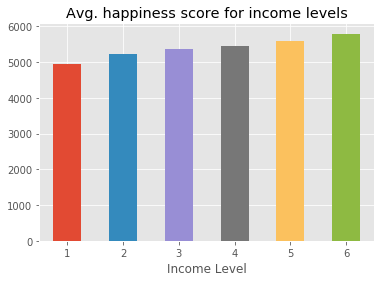

In [19]:
plt.figure()
avg_happiness_for_income_level_adj.plot.bar(rot=0);
plt.title('Avg. happiness score for income levels');
plt.xlabel('Income Level');

In [20]:
rich_scores_max_5 = happy.groupby(['year', 'income_level'])['nscore x percent'].sum().loc[:,(5)]
rich_scores_max_6 = rich_scores_max_5.copy(deep = True)
rich_scores_max_6.loc[happy.groupby(
    ['year', 'income_level'])['nscore x percent'].mean().loc[:,(6)].index] = happy.groupby(['year', 'income_level'])['nscore x percent'].sum().loc[:,(6)]
poor_scores = happy.groupby(['year', 'income_level'])['nscore x percent'].sum().loc[:,(1)]

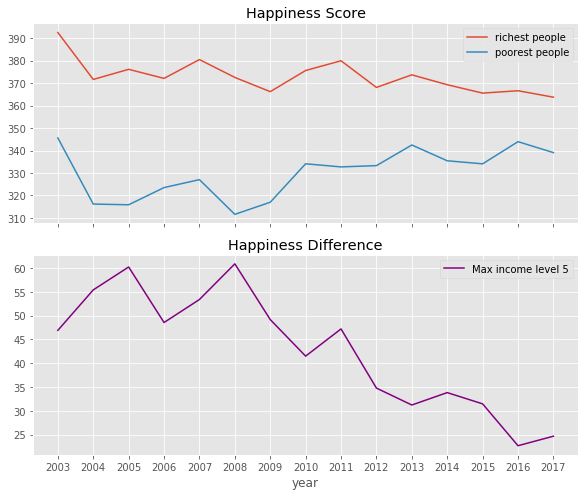

In [21]:
f = plt.figure(figsize = (16,7))
ax1 = plt.subplot(221)
rich_scores_max_5.plot(ax=ax1,
                       label='richest people')
poor_scores.plot(ax=ax1, label= 'poorest people')
plt.legend()
plt.title('Happiness Score')
ax2 = plt.subplot(223,sharex=ax1)
(rich_scores_max_5 - poor_scores).plot(ax=ax2, c = 'purple', label ='Max income level 5')
plt.legend()
plt.xticks(ticks = np.arange(happy['year'].min(), happy['year'].max()+1))
plt.title('Happiness Difference');
plt.tight_layout()

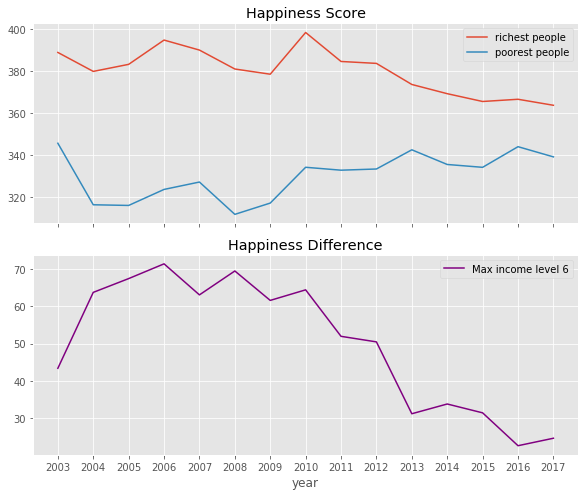

In [22]:
f = plt.figure(figsize = (16,7))
ax1 = plt.subplot(221)
rich_scores_max_6.plot(ax=ax1,
                       label='richest people')
poor_scores.plot(ax=ax1, label= 'poorest people')
plt.legend()
plt.title('Happiness Score')
ax2 = plt.subplot(223,sharex=ax1)
(rich_scores_max_6 - poor_scores).plot(ax=ax2, c = 'purple', label ='Max income level 6')
plt.legend()
plt.xticks(ticks = np.arange(happy['year'].min(), happy['year'].max()+1))
plt.title('Happiness Difference');
plt.tight_layout()

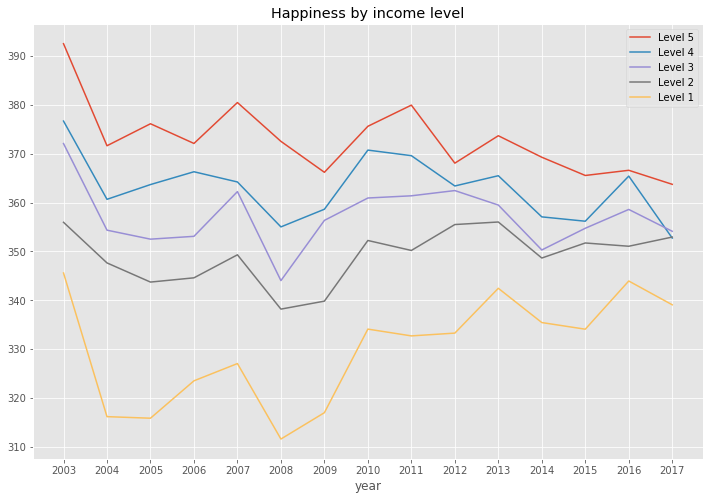

In [23]:
f = plt.figure(figsize = (12,8))
rich_scores_max_5.plot(label = 'Level 5')
for i in range(4):
    happy.groupby(['year', 'income_level'])['nscore x percent'].sum().loc[:,(4-i)].plot(label = f'Level {4-i}')
plt.legend()
plt.xticks(ticks = np.arange(happy['year'].min(), happy['year'].max()+1))
plt.title('Happiness by income level');

In [24]:
average_happiness_score = happy.groupby('year')['nscore x percent'].sum()
average_happiness_score.iloc[0:10] = average_happiness_score.iloc[0:10] * 5 / 6 
# because in the first 10 years there are 6 income levels instead of 5 we normalize the sum by dividing by 6 and multiplying by 5

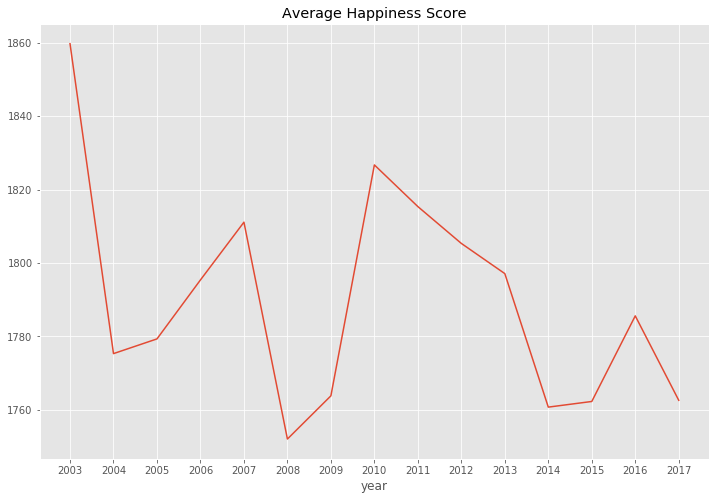

In [25]:
average_happiness_score.plot(figsize = (12,8))
plt.xticks(ticks = np.arange(happy['year'].min(), happy['year'].max()+1))
plt.title('Average Happiness Score');

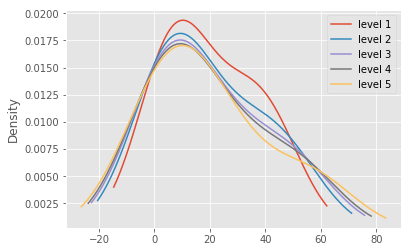

In [63]:
for i in range(5):
    happy[happy['income_level'] == i+1].groupby('new_score')['percent'].mean().plot.kde(label=f'level {i+1}')
plt.legend()

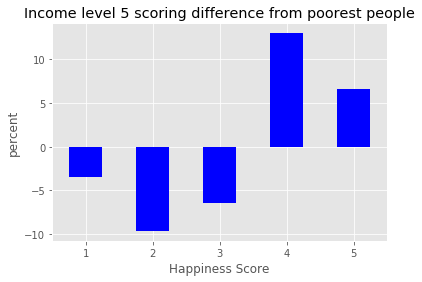

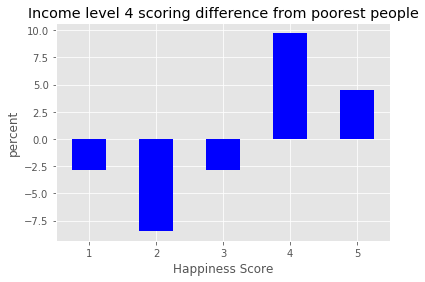

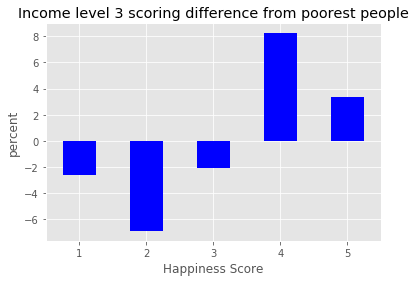

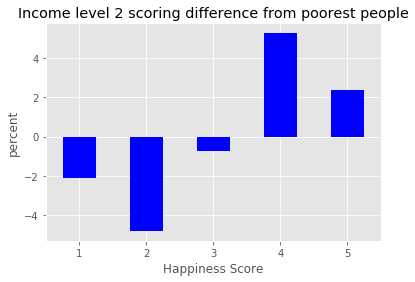

In [79]:
poorest = happy[happy['income_level'] == 1].groupby('new_score')['percent'].mean()
for i in range(4):
    plt.figure()
    (happy[happy['income_level'] == 5-i].groupby('new_score')['percent'].mean() - poorest).plot.bar(color='blue', rot=0)
    plt.xlabel('Happiness Score')
    plt.ylabel('percent')
    plt.title(f'Income level {5-i} scoring difference from poorest people')